# (3) 군집화

<군집화 에 사용된 라이브러리>

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
path="data/통합지수.geojson"
final=gpd.read_file(path, encoding='utf-8')
final.sample(2)

,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,total,Exposure,geometry
282,201000028,0.784301,0.077060,0.000000,경기도 수원시 구운동,0.400809,866566,3.473272e+05,POINT (126.96850 37.28559)
106,201000164,0.343986,0.222097,0.012405,경기도 수원시 평동,0.235386,4667322,1.098624e+06,POINT (126.96369 37.24495)


- 위경도 정보 추출

In [3]:
lonlat=[[i.x,i.y] for i in final.geometry]
final['lon']=[i[0] for i in lonlat]
final['lat']=[i[1] for i in lonlat]

### 최적의 K찾기

In [4]:
target=final
target.head(3)

,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,total,Exposure,geometry,lon,lat
0,202000219,0.419152,0.175779,0.001522,경기도 수원시 매산동,0.255213,46599661,1.189282e+07,POINT (127.00093 37.26746),127.000934,37.267460
1,202000224,0.288980,0.264078,0.001582,경기도 수원시 매산동,0.219256,47134286,1.033446e+07,POINT (127.00341 37.26731),127.003406,37.267314
2,202000208,0.668458,0.050646,0.001330,경기도 수원시 매산동,0.337353,28595407,9.646735e+06,POINT (126.99961 37.26811),126.999608,37.268112


/opt/app-root/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


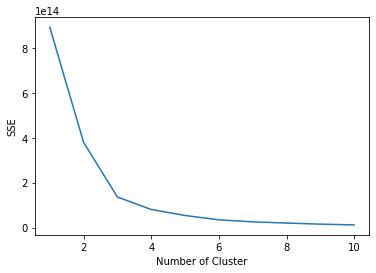

[891334833808378.9,
 379236338700408.2,
 135984589745438.84,
 80526188020696.0,
 53847711916599.76,
 34511975544396.676,
 25550552124377.035,
 20207445970515.6,
 15345038406501.65,
 11907445519080.229]

In [5]:
def elbow(data):
    sse=[]
    for i in range(1,11):
        km=KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(data)
        sse.append(km.inertia_)
    sns.lineplot(range(1,11), sse)
    plt.xlabel('Number of Cluster')
    plt.ylabel('SSE')
    plt.show()
    return sse
target['y']=1
target['Exposure']=final['Exposure']
elbow(target[['Exposure','y']])

In [6]:
kmeans1=KMeans(n_clusters=4,init='k-means++',random_state=0)
kmeans1.fit(target[['Exposure','y']])
target['cluster1']=pd.Categorical(kmeans1.labels_)

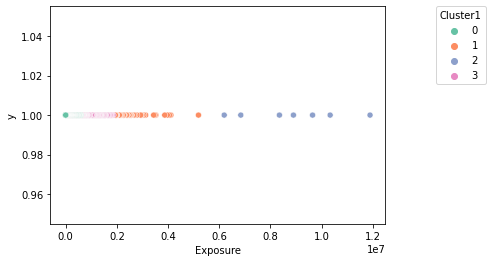

In [7]:
sns.set_palette('Set2')

sns.scatterplot(x='Exposure',y='y',hue='cluster1',data=target,palette='Set2')
plt.legend(title='Cluster1',bbox_to_anchor=(1.3,1),borderaxespad=0)

In [8]:
target.groupby(by='cluster1').Exposure.mean()

cluster1
0    1.486804e+05
1    2.752445e+06
2    8.880559e+06
3    1.045826e+06
Name: Exposure, dtype: float64

In [9]:
kmeans1.score(target[['Exposure','y']])

-80526188020695.98

### 계층적 클러스터링

In [10]:
data=target[['Exposure','y']]
data.index=range(len(data))

In [11]:
row_dist=pd.DataFrame(squareform(pdist(data,metric='euclidean')), columns=range(len(data)) ,index=range(len(data)))

In [12]:
ac=AgglomerativeClustering(n_clusters=4, affinity='euclidean',linkage='complete')
cluster_agg=ac.fit_predict(data)
target['cluster_agg']=cluster_agg

No handles with labels found to put in legend.


Text(0, 0.5, 'Frequency')

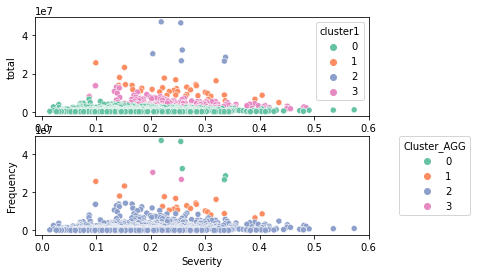

In [13]:
sns.set_palette('Set2')
fig, ax = plt.subplots(nrows=2)

sns.scatterplot(x='sev',y='total',hue='cluster1',data=target,palette='Set2',ax=ax[0])
plt.legend(title='Cluster2_Kmeans++',bbox_to_anchor=(1.3,1),borderaxespad=0)
plt.xlabel('Severity')
plt.ylabel('Frequency')


sns.scatterplot(x='sev',y='total',hue='cluster_agg',data=target,palette='Set2',ax=ax[1])
plt.legend(title='Cluster_AGG',bbox_to_anchor=(1.3,1),borderaxespad=0)
plt.xlabel('Severity')
plt.ylabel('Frequency')


No handles with labels found to put in legend.


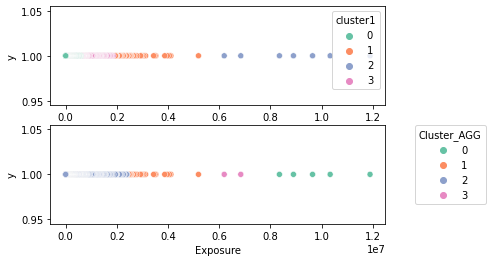

In [14]:
fig, ax = plt.subplots(nrows=2)

sns.scatterplot(x='Exposure',y='y',hue='cluster1',data=target,palette='Set2',ax=ax[0])
plt.legend(title='Cluster2_Kmeans++',bbox_to_anchor=(1.3,1),borderaxespad=0)

sns.scatterplot(x='Exposure',y='y',hue='cluster_agg',data=target,palette='Set2',ax=ax[1])
plt.legend(title='Cluster_AGG',bbox_to_anchor=(1.3,1),borderaxespad=0)

In [15]:
target.groupby(by='cluster1').count()

,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,total,Exposure,geometry,lon,lat,y,cluster_agg
cluster1,,,,,,,,,,,,,
0,732,732,732,732,732,732,732,732,732,732,732,732,732
1,37,37,37,37,37,37,37,37,37,37,37,37,37
2,7,7,7,7,7,7,7,7,7,7,7,7,7
3,143,143,143,143,143,143,143,143,143,143,143,143,143


In [16]:
target.groupby(by='cluster_agg').count()

,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,total,Exposure,geometry,lon,lat,y,cluster1
cluster_agg,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5
1,21,21,21,21,21,21,21,21,21,21,21,21,21
2,891,891,891,891,891,891,891,891,891,891,891,891,891
3,2,2,2,2,2,2,2,2,2,2,2,2,2


In [17]:
target['cluster1']=target['cluster1'].astype('int64')

target.to_file('data/미세먼지저감_군집화.geojson',driver='GeoJSON',index=False)

In [18]:
cat1=gpd.read_file('data/미세먼지저감_군집화.geojson')
cat1

,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,total,Exposure,lon,lat,y,cluster1,cluster_agg,geometry
0,202000219,0.419152,0.175779,0.001522,경기도 수원시 매산동,0.255213,46599661,1.189282e+07,127.000934,37.267460,1,2,0,POINT (127.00093 37.26746)
1,202000224,0.288980,0.264078,0.001582,경기도 수원시 매산동,0.219256,47134286,1.033446e+07,127.003406,37.267314,1,2,0,POINT (127.00341 37.26731)
2,202000208,0.668458,0.050646,0.001330,경기도 수원시 매산동,0.337353,28595407,9.646735e+06,126.999608,37.268112,1,2,0,POINT (126.99961 37.26811)
3,203000150,0.549781,0.176911,0.079344,경기도 수원시 태장동,0.335274,26545428,8.899994e+06,127.056186,37.244730,1,2,0,POINT (127.05619 37.24473)
4,202000106,0.424874,0.175779,0.001549,경기도 수원시 매산동,0.257973,32378188,8.352690e+06,127.000904,37.267365,1,2,0,POINT (127.00090 37.26737)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,201000391,0.155830,0.222097,0.012023,경기도 수원시 평동,0.144736,1310,1.896042e+02,126.969126,37.242906,1,0,2,POINT (126.96913 37.24291)
915,203000308,0.248861,0.133506,0.015949,경기도 수원시 광교1동,0.163590,1040,1.701339e+02,127.066725,37.275450,1,0,2,POINT (127.06672 37.27545)
916,203000438,0.264541,0.062335,0.000000,경기도 수원시 광교1동,0.146175,1126,1.645928e+02,127.056198,37.294917,1,0,2,POINT (127.05620 37.29492)
917,201000393,0.258489,0.222097,0.013152,경기도 수원시 평동,0.194394,625,1.214965e+02,126.969778,37.241166,1,0,2,POINT (126.96978 37.24117)


In [19]:
cat1[:3]

,정류장ID,총합,도로재비산심각도,최소최대정규화오염도,위치(동),sev,total,Exposure,lon,lat,y,cluster1,cluster_agg,geometry
0,202000219,0.419152,0.175779,0.001522,경기도 수원시 매산동,0.255213,46599661,1.189282e+07,127.000934,37.267460,1,2,0,POINT (127.00093 37.26746)
1,202000224,0.288980,0.264078,0.001582,경기도 수원시 매산동,0.219256,47134286,1.033446e+07,127.003406,37.267314,1,2,0,POINT (127.00341 37.26731)
2,202000208,0.668458,0.050646,0.001330,경기도 수원시 매산동,0.337353,28595407,9.646735e+06,126.999608,37.268112,1,2,0,POINT (126.99961 37.26811)


In [20]:
cat1=cat1[['정류장ID','Exposure', 'lon', 'lat','cluster1','cluster_agg']]
cat1.reset_index(inplace=True,drop=True)

cat1[:4]

,정류장ID,Exposure,lon,lat,cluster1,cluster_agg
0,202000219,1.189282e+07,127.000934,37.267460,2,0
1,202000224,1.033446e+07,127.003406,37.267314,2,0
2,202000208,9.646735e+06,126.999608,37.268112,2,0
3,203000150,8.899994e+06,127.056186,37.244730,2,0


In [21]:
cat1=cat1.sort_values(by='Exposure',ascending=False)
cat1.groupby('cluster1')['Exposure'].mean()

cluster1
0    1.486804e+05
1    2.752445e+06
2    8.880559e+06
3    1.045826e+06
Name: Exposure, dtype: float64

In [22]:
cat1_score=np.where(cat1.cluster1==1,7.5,np.where(cat1.cluster1==2,10,np.where(cat1.cluster1==3,5,2.5)))
cat1['category1_score']=cat1_score
cat1

,정류장ID,Exposure,lon,lat,cluster1,cluster_agg,category1_score
0,202000219,1.189282e+07,127.000934,37.267460,2,0,10.0
1,202000224,1.033446e+07,127.003406,37.267314,2,0,10.0
2,202000208,9.646735e+06,126.999608,37.268112,2,0,10.0
3,203000150,8.899994e+06,127.056186,37.244730,2,0,10.0
4,202000106,8.352690e+06,127.000904,37.267365,2,0,10.0
...,...,...,...,...,...,...,...
914,201000391,1.896042e+02,126.969126,37.242906,0,2,2.5
915,203000308,1.701339e+02,127.066725,37.275450,0,2,2.5
916,203000438,1.645928e+02,127.056198,37.294917,0,2,2.5
917,201000393,1.214965e+02,126.969778,37.241166,0,2,2.5


구간별 순위에 따른 점수 변동 폭

In [23]:
delta=2.5/cat1.groupby('category1_score').size()
delta

category1_score
2.5     0.003415
5.0     0.017483
7.5     0.067568
10.0    0.357143
dtype: float64

In [24]:
delta.index

Float64Index([2.5, 5.0, 7.5, 10.0], dtype='float64', name='category1_score')


### 점수계산: 군집별로 10점을 등분, 각 군집 내 개수로 서열화 점수


In [25]:
adjust_score=[]
for score in delta.index[::-1]:
    adjust_score.extend([i*delta[score]for i in range(cat1.groupby('category1_score').size()[score])])

cat1['category1_score']=cat1['category1_score']-adjust_score
cat1

,정류장ID,Exposure,lon,lat,cluster1,cluster_agg,category1_score
0,202000219,1.189282e+07,127.000934,37.267460,2,0,10.000000
1,202000224,1.033446e+07,127.003406,37.267314,2,0,9.642857
2,202000208,9.646735e+06,126.999608,37.268112,2,0,9.285714
3,203000150,8.899994e+06,127.056186,37.244730,2,0,8.928571
4,202000106,8.352690e+06,127.000904,37.267365,2,0,8.571429
...,...,...,...,...,...,...,...
914,201000391,1.896042e+02,126.969126,37.242906,0,2,0.017077
915,203000308,1.701339e+02,127.066725,37.275450,0,2,0.013661
916,203000438,1.645928e+02,127.056198,37.294917,0,2,0.010246
917,201000393,1.214965e+02,126.969778,37.241166,0,2,0.006831


결과물 저장하기

In [26]:
cat1.to_csv('data/category1.csv',encoding='utf-8-sig', index=False)